# Image Classification using ResNet18

In [28]:
import random
import os

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from pathlib import Path
import PIL
from PIL import UnidentifiedImageError
from PIL import Image
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler


## Data Preprocessing

In [29]:
#Define the path to the images
DIR = 'images'
#Define the parameters for the model
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)
EPOCHS = 10
LEARNING_RATE = 0.0001

print(f"There are {len(os.listdir(DIR))} images in training set")

There are 5762 images in training set


In [30]:
file_names = os.listdir(DIR)
file_names[:10]

['00003aeb-ace5-43bf-9a0c-dc31a03e9cd2.jpg',
 '00070a23-9faf-4682-8243-59f307880f4b.jpg',
 '000d31f6-44b5-4758-8d86-c4fcfb234392.jpg',
 '001068a8-86c3-4029-a9d9-1e27015e7e64.jpg',
 '00143901-a14c-4600-960f-7747b4a3a8cd.jpg',
 '00149032-3dd6-426e-9bc0-d53032536a42.jpg',
 '00208c77-ee58-4b63-bc1a-b9b3aa4f1be0.jpg',
 '0028956e-9962-46f0-ad45-2c42f8a59d94.jpg',
 '002e88c2-e0ce-4a4b-9670-eddc3d99accc.jpg',
 '002eb5b8-6541-42a3-9596-0d94f7b866ae.jpg']

In [31]:
data = pd.read_csv('images.csv')
data.head() 

,image,sender_id,label,kids
0,4285fab0-751a-4b74-8e9b-43af05deee22,124,Not sure,False
1,ea7b6656-3f84-4eb3-9099-23e623fc1018,148,T-Shirt,False
2,00627a3f-0477-401c-95eb-92642cbe078d,94,Not sure,False
3,ea2ffd4d-9b25-4ca8-9dc2-bd27f1cc59fa,43,T-Shirt,False
4,3b86d877-2b9e-4c8b-a6a2-1d87513309d0,189,Shoes,False


In [32]:
data['image'] = data['image']+'.jpg'
data_1 = data[['image', 'label']]
data_1.head()

,image,label
0,4285fab0-751a-4b74-8e9b-43af05deee22.jpg,Not sure
1,ea7b6656-3f84-4eb3-9099-23e623fc1018.jpg,T-Shirt
2,00627a3f-0477-401c-95eb-92642cbe078d.jpg,Not sure
3,ea2ffd4d-9b25-4ca8-9dc2-bd27f1cc59fa.jpg,T-Shirt
4,3b86d877-2b9e-4c8b-a6a2-1d87513309d0.jpg,Shoes


***Remove corrupted images from the dataset***

In [33]:
path = Path(DIR).rglob("*.jpg")
for img_p in path:
    try:
        img = PIL.Image.open(img_p)
    except PIL.UnidentifiedImageError:
            print(img_p)

images\040d73b7-21b5-4cf2-84fc-e1a80231b202.jpg


images\1d0129a1-f29a-4a3f-b103-f651176183eb.jpg
images\784d67d4-b95e-4abb-baf7-8024f18dc3c8.jpg
images\b72ed5cd-9f5f-49a7-b12e-63a078212a17.jpg
images\c60e486d-10ed-4f64-abab-5bb698c736dd.jpg
images\d028580f-9a98-4fb5-a6c9-5dc362ad3f09.jpg


In [34]:
corrupted = ['b72ed5cd-9f5f-49a7-b12e-63a078212a17.jpg', '1d0129a1-f29a-4a3f-b103-f651176183eb.jpg', 'c60e486d-10ed-4f64-abab-5bb698c736dd.jpg', 
            'd028580f-9a98-4fb5-a6c9-5dc362ad3f09.jpg', '040d73b7-21b5-4cf2-84fc-e1a80231b202.jpg', '784d67d4-b95e-4abb-baf7-8024f18dc3c8.jpg']

data_1 = data_1.drop(data_1[data_1['image'].isin(corrupted)].index, axis=0)

In [35]:
class_names = list(data_1['label'].unique())
print(len(class_names))
class_names

class_dict = dict(zip(class_names, range(len(class_names))))
labels_to_remove = ['Skip', 'Not sure', 'Other', 'Blouse']
data_1 = data_1[~data_1['label'].isin(labels_to_remove)]

#Label encoding
class_names = list(data_1['label'].unique())
class_dict = dict(zip(class_names, range(len(class_names))))
print(len(class_names))
class_dict


20
16


{'T-Shirt': 0,
 'Shoes': 1,
 'Shorts': 2,
 'Shirt': 3,
 'Pants': 4,
 'Skirt': 5,
 'Top': 6,
 'Outwear': 7,
 'Dress': 8,
 'Body': 9,
 'Longsleeve': 10,
 'Undershirt': 11,
 'Hat': 12,
 'Polo': 13,
 'Hoodie': 14,
 'Blazer': 15}

## Training and Validation

In [36]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, image_folder, class_dict, transform=None):
        self.dataframe = dataframe
        self.image_folder = image_folder
        self.transform = transform
        self.class_dict = class_dict
        self.dataframe['label'] = self.dataframe['label'].map(self.class_dict)

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx, 0]
        img_path = os.path.join(self.image_folder, img_name)
        
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)

        label = torch.tensor(self.dataframe.iloc[idx, 1], dtype=torch.long)

        return image, label

    def inverse_class_mapping(self, encoded_labels):
        return [key for key, value in self.class_dict.items() if value in encoded_labels.numpy()]

# Define the transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])



batch_size_train = BATCH_SIZE
batch_size_val = 1024
batch_size_test = 1024

# Assume your DataFrame data_1 is the one you provided
# Split the dataset into training and validation sets

train_df, temp_df = train_test_split(data_1, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

#OverSampling

# Count the number of samples in each class for oversampling
class_counts = train_df['label'].value_counts().to_dict()
print ("Label counts before oversampling: ", class_counts)
# Oversample the minority classes in the training set (all except the majority class)
oversampler = RandomOverSampler(sampling_strategy='not majority', random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(train_df[['image']], train_df['label'])
X_resampled_flat = X_resampled.values.reshape(-1)
# Create instances of the dataset and data loaders for oversampled data
oversampled_train_df = pd.DataFrame({'image': X_resampled_flat, 'label': y_resampled})
class_counts_2 = oversampled_train_df['label'].value_counts().to_dict()
print ("Label counts after oversampling: ", class_counts_2)
oversampled_train_dataset = CustomDataset(oversampled_train_df, DIR, class_dict, transform=transform)
oversampled_train_loader = DataLoader(oversampled_train_dataset, batch_size=batch_size_train, shuffle=True)


# Undersampling 
""" class_counts = train_df['label'].value_counts().to_dict()
print("Label counts before undersampling: ", class_counts)
# Undersample the majority classes in the training set (all except the minority class)
undersampler = RandomUnderSampler(sampling_strategy='not minority', random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(train_df[['image']], train_df['label'])

X_resampled_flat = X_resampled.values.reshape(-1)
# Create instances of the dataset and data loaders for undersampled data
undersampled_train_df = pd.DataFrame({'image': X_resampled_flat, 'label': y_resampled})
class_counts_2 = undersampled_train_df['label'].value_counts().to_dict()
print("Label counts after undersampling: ", class_counts_2)
undersampled_train_dataset = CustomDataset(undersampled_train_df, DIR, class_dict, transform=transform)
undersampled_train_loader = DataLoader(undersampled_train_dataset, batch_size=batch_size_train, shuffle=True) """

#OverSampling + Undersampling
"""
# Count the number of samples in each class for oversampling
class_counts = train_df['label'].value_counts().to_dict()
print("Label counts before oversampling + undersampling: ", class_counts)

# Oversample the minority classes in the training set 
oversampler = RandomOverSampler(sampling_strategy='not majority', random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(train_df[['image']], train_df['label'])
X_resampled_flat = X_resampled.values.reshape(-1)

# Undersample the majority classes in the training set
undersampler = RandomUnderSampler(sampling_strategy={label: 200 for label in class_counts}, random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(pd.DataFrame({'image': X_resampled_flat}), y_resampled)
X_resampled_flat = X_resampled.values.reshape(-1)

# Create instances of the dataset and data loaders for oversampled and undersampled data
oversampled_and_undersampled_train_df = pd.DataFrame({'image': X_resampled_flat, 'label': y_resampled})
class_counts_2 = oversampled_and_undersampled_train_df['label'].value_counts().to_dict()
print("Label counts after oversampling + undersampling: ", class_counts_2)
oversampled_and_undersampled_train_dataset = CustomDataset(oversampled_and_undersampled_train_df, DIR, class_dict, transform=transform)
oversampled_and_undersampled_train_loader = DataLoader(oversampled_and_undersampled_train_dataset, batch_size=batch_size_train, shuffle=True)
"""



# Create instances of the dataset and data loaders
class_dict = dict(zip(class_names, range(len(class_names))))
train_dataset = CustomDataset(train_df, DIR, class_dict, transform=transform)
val_dataset = CustomDataset(val_df, DIR, class_dict, transform=transform)
test_dataset = CustomDataset(test_df, DIR, class_dict, transform=transform)


train_loader = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size_val, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size_test, shuffle=False)

# Load the pretrained ResNet model
model = models.resnet18(pretrained=True)

# Modify the last fully connected layer to match the number of classes
num_classes = len(class_names)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Train the model
num_epochs = EPOCHS

patience = 10  # Number of epochs with no improvement after which training will be stopped

best_val_loss = float('inf')
epochs_without_improvement = 0

# Losses and accuracies
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train_predictions = 0
    total_train_samples = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train_samples += labels.size(0)
        correct_train_predictions += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_accuracy = correct_train_predictions / total_train_samples
    train_accuracies.append(train_accuracy)
    print(f'Epoch {epoch + 1}/{num_epochs}, Training Loss: {train_losses[-1]}, Training Accuracy: {train_accuracies[-1] * 100:.2f}%')

    # Evaluate on the validation set
    model.eval()
    running_val_loss = 0.0
    correct_val_predictions = 0
    total_val_samples = 0

    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_labels)
            running_val_loss += val_loss.item()

            _, val_predicted = torch.max(val_outputs.data, 1)
            total_val_samples += val_labels.size(0)
            correct_val_predictions += (val_predicted == val_labels).sum().item()

    val_losses.append(running_val_loss / len(val_loader))
    val_accuracy = correct_val_predictions / total_val_samples
    val_accuracies.append(val_accuracy)
    print(f'Epoch {epoch + 1}/{num_epochs}, Validation Loss: {val_losses[-1]}, Validation Accuracy: {val_accuracies[-1] * 100:.2f}%')

    # Early stopping
    """ if val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1]
            epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f'Early stopping after {epoch + 1} epochs without improvement.')
        break """


Label counts before oversampling:  {'T-Shirt': 801, 'Longsleeve': 569, 'Pants': 557, 'Shoes': 334, 'Shirt': 305, 'Dress': 287, 'Outwear': 252, 'Shorts': 249, 'Hat': 139, 'Skirt': 127, 'Undershirt': 98, 'Polo': 96, 'Blazer': 88, 'Hoodie': 79, 'Body': 51, 'Top': 26}
Label counts after oversampling:  {'Shirt': 801, 'Longsleeve': 801, 'T-Shirt': 801, 'Dress': 801, 'Shoes': 801, 'Skirt': 801, 'Pants': 801, 'Shorts': 801, 'Outwear': 801, 'Body': 801, 'Hat': 801, 'Polo': 801, 'Undershirt': 801, 'Blazer': 801, 'Hoodie': 801, 'Top': 801}


C:\Users\fabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\fabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10, Training Loss: 1.0721937274838995, Training Accuracy: 68.83%
Epoch 1/10, Validation Loss: 0.5738634467124939, Validation Accuracy: 81.46%
Epoch 2/10, Training Loss: 0.28870891110868907, Training Accuracy: 92.21%
Epoch 2/10, Validation Loss: 0.45452356338500977, Validation Accuracy: 86.79%
Epoch 3/10, Training Loss: 0.0892435270911596, Training Accuracy: 98.72%
Epoch 3/10, Validation Loss: 0.4391059875488281, Validation Accuracy: 87.38%
Epoch 4/10, Training Loss: 0.031805089865554505, Training Accuracy: 99.80%
Epoch 4/10, Validation Loss: 0.41273123025894165, Validation Accuracy: 87.18%
Epoch 5/10, Training Loss: 0.014498821467043847, Training Accuracy: 99.98%
Epoch 5/10, Validation Loss: 0.4120064079761505, Validation Accuracy: 87.57%
Epoch 6/10, Training Loss: 0.00933808627479717, Training Accuracy: 99.98%
Epoch 6/10, Validation Loss: 0.4360390305519104, Validation Accuracy: 86.79%
Epoch 7/10, Training Loss: 0.006666834364410519, Training Accuracy: 99.98%
Epoch 7/10, Valid

## Evaluation

In [37]:
# Evaluation
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 88.39%


## Plots

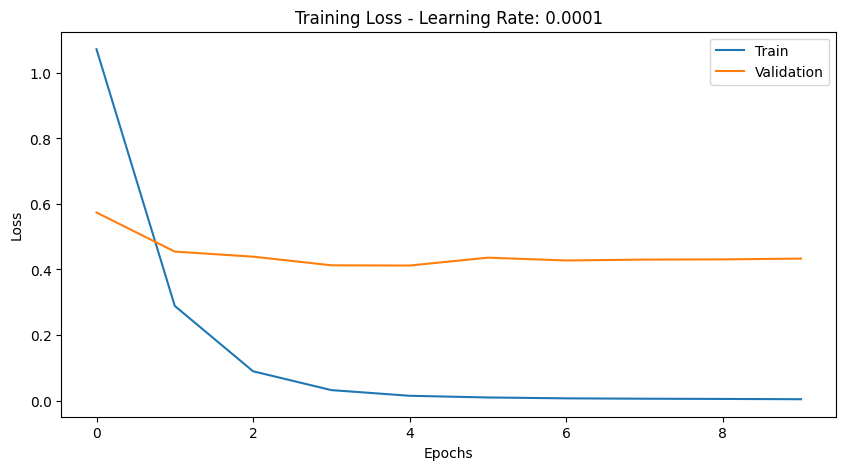

In [38]:
# Plot the losses 
plt.figure(figsize=(10, 5))
plt.title('Training Loss - Learning Rate: 0.0001')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.legend()
plt.show()

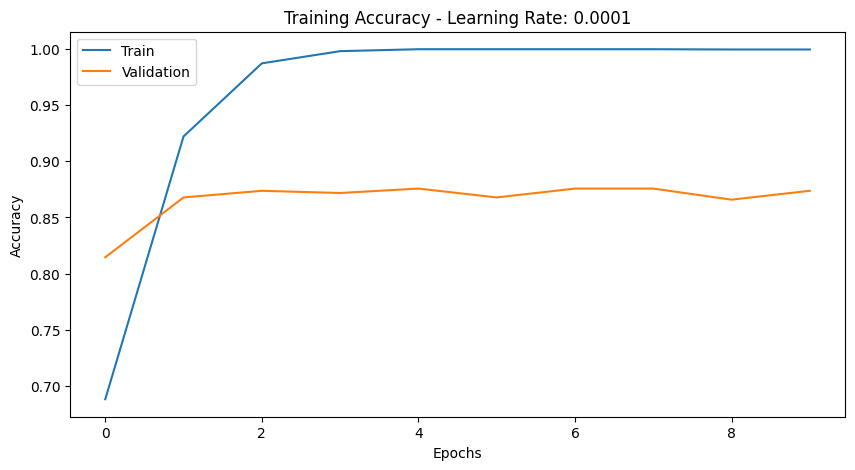

In [39]:
# Plot the accuracies
plt.figure(figsize=(10, 5))
plt.title('Training Accuracy - Learning Rate: 0.0001')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(train_accuracies, label='Train')
plt.plot(val_accuracies, label='Validation')
plt.legend()
plt.show()

## Prediction on test images 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


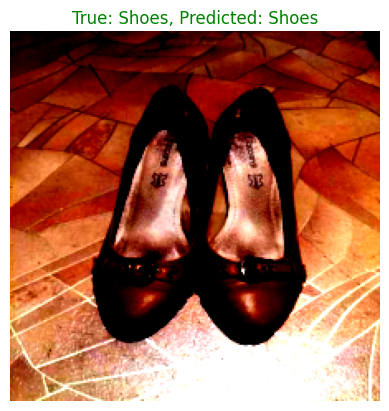

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


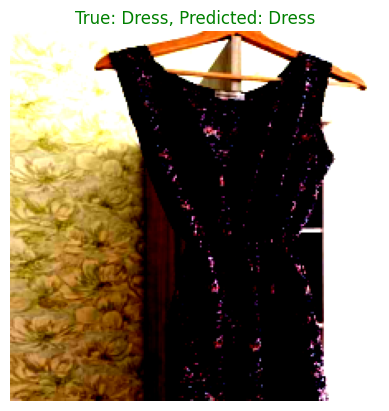

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


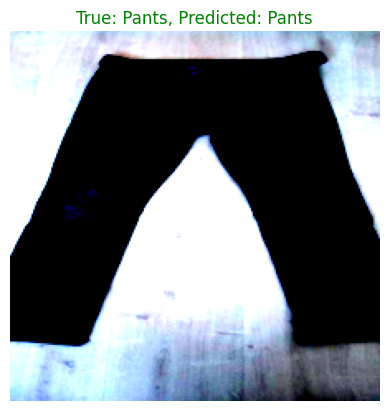

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


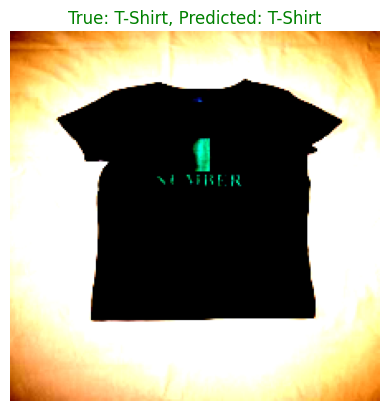

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


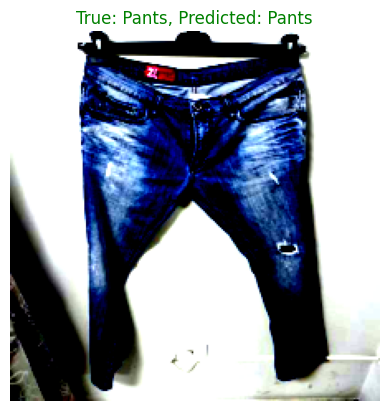

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


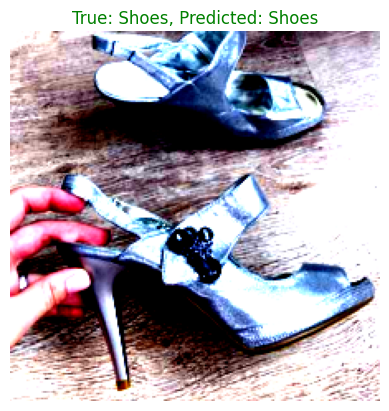

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


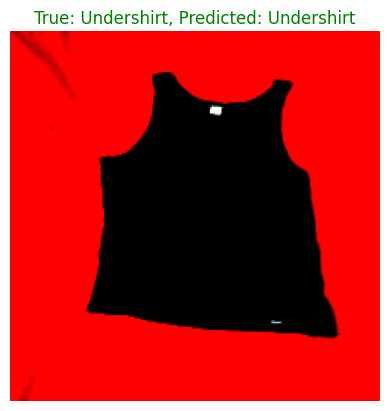

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


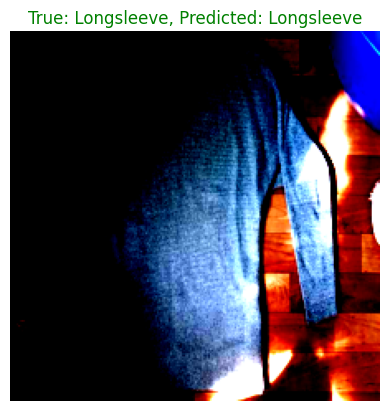

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


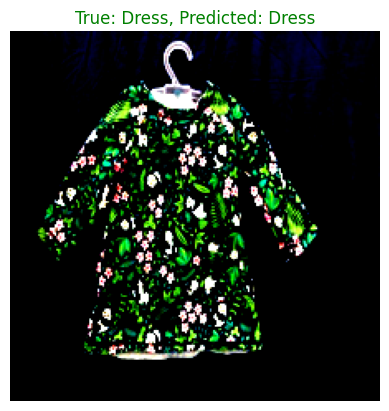

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


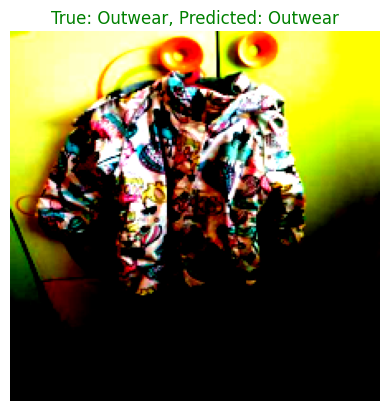

In [40]:
subset_loader = torch.utils.data.DataLoader(test_dataset, batch_size=10, shuffle=True)
data_iter = iter(subset_loader)

# Set the model to evaluation mode
model.eval()

# Loop through the subset and visualize predictions
for i in range(10):
    # Get a batch of data
    inputs, labels = next(data_iter)

    # Make predictions
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)

    # Convert to numpy arrays
    img = np.transpose(inputs[0].numpy(), (1, 2, 0))
    true_label = labels[0].item()
    predicted_label = preds[0].item()

    # Plot the image with green if the prediction is correct, red otherwise
    color = 'green' if true_label == predicted_label else 'red'
    plt.title(f"True: {class_names[true_label]}, Predicted: {class_names[predicted_label]}", color=color)
    plt.imshow(img)
    plt.axis('off')
    plt.show()